In [1]:
import torch as tr
import numpy as np

import itertools

from PM_models import *
from PM_tasks import *
from help_amtask import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# sweep 2
- evaluating effect of pre-training

In [2]:
nmaps = 4
fdir = 'model_data/amtask-barcode/'
nnets = 20
instdimL=[8,10,12]
stimdimL=[8,10,12]
stsizeL=[4,5,6,8]

In [7]:
def load_trsc2(st,inst,stim,seed,pretrain=True):
  if pretrain:
    curr = '1000_29000'
  else:
    curr = '0_30000'
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-trsc.npy"%(st,inst,stim,curr,seed)
  trsc = np.load(fdir+fpath)
  return trsc

def load_trsc(st,inst,stim,seed):
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-seed_%i-trsc.npy"%(st,inst,stim,seed)
  trsc = np.load(fdir+fpath)
  return trsc

def load_trsc_group(st,inst,stim,nnets=20,load_trsc_fn=load_trsc):
  L = []
  for seed in range(nnets):
    trsc = load_trsc_fn(st,inst,stim,seed)
    L.append(trsc)
  return np.array(L)

def plt_trsc(ax,trsc,mawind=500):
  '''trsc [sub,neps,ntr,trlen]'''
  cL = ['b','purple']
  for sub in range(len(trsc)):
    for trial in [0,1]:
      trsc_tr = trsc[sub,:,trial,nmaps:].mean(-1)
      tracc = mov_avg(trsc_tr,mawind)
      ax.plot(tracc,c=cL[trial],lw=.5,zorder=100*trial)
      ax.axhline(0.25,c='r',lw=.1,ls='--')
  return None


## training acc

In [ ]:
f=2
nnets = 20
for st in stsizeL:
  plt.close('all')
  fig,axarr = plt.subplots(3,3,figsize=(f*15,f*10),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  plt.suptitle('stsize=%i'%st)
  for idx,(inst,stim) in enumerate(itertools.product(stimdimL,instdimL)):
    ax = axarr[idx]
    title = 'instdim_%i-stimdim_%i'%(inst,stim)
    ax.set_title(title)
    ## load group data
    trsc = load_trsc_group(st,inst,stim,nnets=nnets,load_trsc_fn=load_trsc)
    ## plot group data
    plt_trsc(ax,trsc)
  plt.savefig('figures/amtask-barcodes/tracc/'+'sweep1-pretrain-stsize-%i'%st)


## eval acc

In [40]:
def load_evsc2(st,inst,stim,seed,pretrain=True):
  if pretrain: curr = '1000_29000'
  else: curr = '0_30000'
  L = []
  for em in [0,1]:
    fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-ev_em_%i-evsc.npy"%(st,inst,stim,curr,seed,em)
    trsc = np.load(fdir+fpath)
    L.append(trsc)
  return np.array(L)

def load_evsc(st,inst,stim,seed):
  L = []
  for em in [0,1]:
    fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-seed_%i-ev_em_%i-evsc.npy"%(st,inst,stim,seed,em)
    trsc = np.load(fdir+fpath)
    L.append(trsc)
  return np.array(L)

def load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc):
  L = []
  for seed in range(nnets):
    trsc = load_data_fn(st,inst,stim,seed)
    L.append(trsc)
  return np.array(L)

In [41]:
def plt_trial_acc(ax,evsc,plt_subs=True):
  '''evsc [nsubs,(em0,em1),neps,ntr,trlen]
  '''
  evacc = evsc[:,:,:,:,nmaps:].mean((2,-1))
  M = evacc.mean(0)
  S = evacc.std(0)/np.sqrt(len(evacc))
  cL = ['r','b']
  ## plt eval with and without EM
  for em in [0,1]:
    ax.plot(M[em],c=cL[em],lw=2)
    ax.scatter(range(len(M[em])),M[em],c='k')
    ax.fill_between(range(len(M[em])),M[em]-S[em],M[em]+S[em],alpha=.3,color=cL[em])
    if plt_subs:
      for sacc in evacc:
        ax.plot(sacc[em],c=cL[em],lw=.1)
  return None


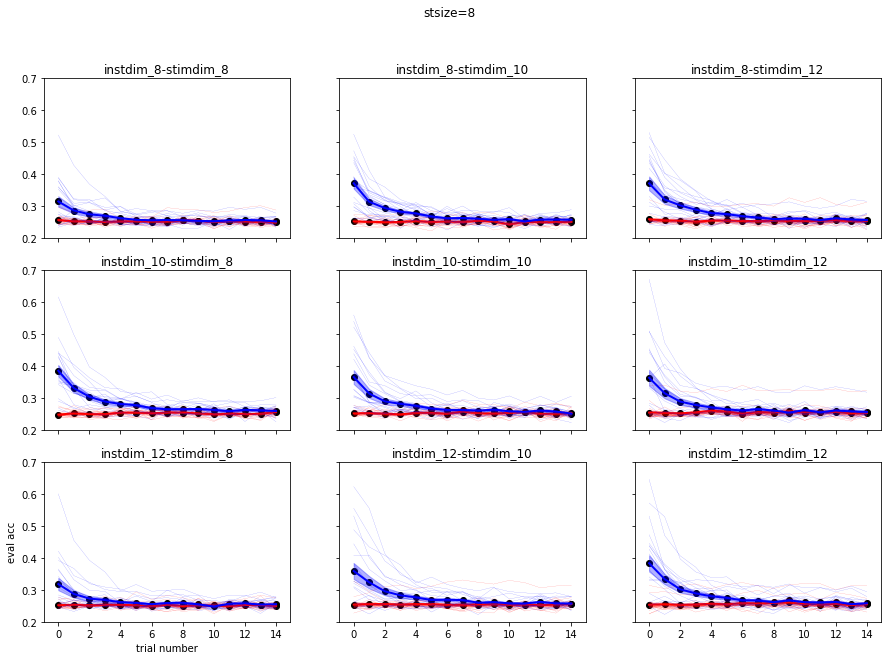

In [64]:
f=1
nnets = 20
for st in stsizeL:
  plt.close('all')
  fig,axarr = plt.subplots(3,3,figsize=(f*15,f*10),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  axarr[6].set_xlabel('trial number')
  axarr[6].set_ylabel('eval acc')
  plt.suptitle('stsize=%i'%st)
  for idx,(inst,stim) in enumerate(itertools.product(stimdimL,instdimL)):
    ax = axarr[idx]
    ax.set_ylim(0.2,0.7)
    title = 'instdim_%i-stimdim_%i'%(inst,stim)
    ax.set_title(title)
    ## load group data
    evsc = load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc)
    ## plot
    plt_trial_acc(ax,evsc)
  plt.savefig('figures/amtask-barcodes/evacc/'+'sweep1_pretrain-stsize_%i'%st)

### load net

In [ ]:
st,inst,stim = 4,10,12
evsc = load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc2)

# train and eval

In [ ]:
wmsize=4
emsetting=1
seed=5
instdim=12
stimdim=10

net = NetBarCode(wmsize=wmsize,
                 emsetting=emsetting,
                 seed=seed,
                 instdim=instdim,
                 stimdim=stimdim,
                 debug=False)

nmaps = 4
task = TaskArbitraryMaps(nmaps,
                         switchmaps=True,
                         ntokens_surplus=0,
                         seed=seed,
                         stimdim=stimdim)

In [ ]:
trscL = []
nblocks = 4
emkL = ['stim','conj','stim','conj']
nepsL = [600,10000,600,10000,]
ntrL = [1,2]
for idx in range(nblocks):
  net.emk=emkL[idx]
  trsc = run_net(net,task,nepsL[idx],2,1,training=True)
  trscL.append(trsc[:,:,nmaps:])
trsc = np.concatenate(trscL)

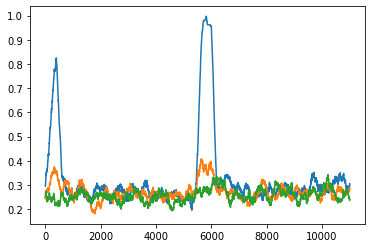

In [62]:
for acc in tracc.T:
  plt.plot(mov_avg(acc,200))

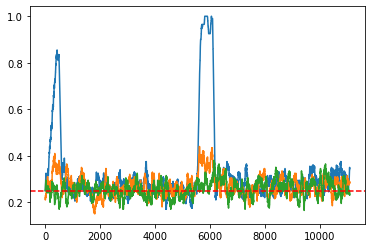

In [56]:
tracc = trsc.mean(-1)

for idx,a in enumerate(tracc.T):
  plt.plot(mov_avg(a,100))
plt.axhline(0.25,c='r',ls='--')

In [6]:
net.debug=True
i,x,y = task.gen_ep_data(4,1)
yh = net(i,x)



st tensor(0.5488)
wm tensor(0.9888)
em tensor(0.)

st tensor(0.7917)
wm tensor(0.0006)
em tensor(0.)

st tensor(0.3595)
wm tensor(0.0427)
em tensor(0.)

st tensor(0.9786)
wm tensor(0.9995)
em tensor(0.)

qkdist2 [0.15  0.035 0.113 0.081]

st tensor(0.5488)
wm tensor(0.9435)
em tensor(0.0006)

st tensor(0.5488)
wm tensor(0.9983)
em tensor(0.)

st tensor(0.3595)
wm tensor(0.0227)
em tensor(0.)

st tensor(0.9786)
wm tensor(0.0012)
em tensor(0.)

st tensor(0.2646)
wm tensor(0.9997)
em tensor(0.)

qkdist2 [0.162 0.038 0.122 0.082 0.118 0.124 0.034 0.087]

st tensor(0.9786)
wm tensor(0.9422)
em tensor(0.0012)

st tensor(0.2646)
wm tensor(0.0016)
em tensor(0.)

st tensor(0.5488)
wm tensor(0.0395)
em tensor(0.)

st tensor(0.9786)
wm tensor(0.9997)
em tensor(0.)

st tensor(0.3595)
wm tensor(0.9973)
em tensor(0.)

qkdist2 [0.151 0.034 0.113 0.08  0.108 0.114 0.033 0.081 0.033 0.099 0.08  0.105]

st tensor(0.5488)
wm tensor(0.9292)
em tensor(0.0012)

st tensor(0.7917)
wm tensor(0.9998)
em tensor

0.0 0.75
0.2 0.7333333333333333
0.4 0.7666666666666667
0.6 0.7333333333333333
0.8 0.7333333333333333
0.0 0.8
0.2 0.7333333333333333
0.4 0.8
0.6 0.7333333333333333
0.8 0.8166666666666667


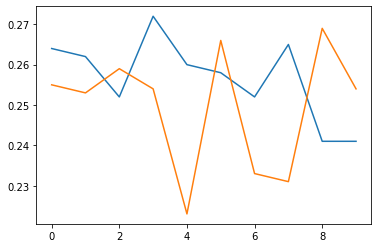

In [7]:
net.debug=False
for em in [1,0]:
  net.EMsetting=em
  evsc = run_net(net,task,500,10,2,training=False)
  evacc = evsc[:,:,nmaps:]
  plt.plot(evacc.mean((0,2)))